<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Cifar-100-128-fine/resized/15*15/cifar100_fine_15_15_Gabor_Random_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [ ]:
!unzip /content/drive/My\ Drive/Mehang\ Rai/cifar100_128_fine.zip -d cifar100_128_fine

In [16]:
ITERATION = 1
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42, 42, 57, 48, 86, 7, 15, 28, 39, 52][ITERATION-1]
BATCH_SIZE = 32
NUM_CLASSES = 100
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 32
TRAIN_DIR = "cifar100_128_fine/cifar100_128_fine/train/"
TEST_DIR = "cifar100_128_fine/cifar100_128_fine/test/"
# TEST_DIR = "cifar100_128_fine/cifar100_128_fine/train/"
# TRAIN_DIR = "cifar100_128_fine/cifar100_128_fine/test/"

In [17]:
filenames = os.listdir(TRAIN_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

filenames = os.listdir(TEST_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

validate_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [18]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

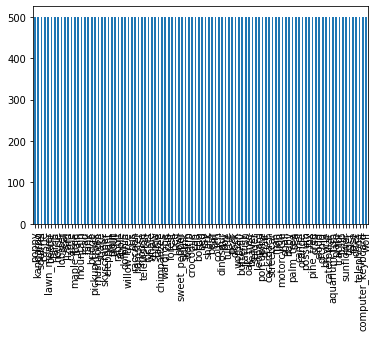

In [19]:
train_df['category'].value_counts().plot.bar()

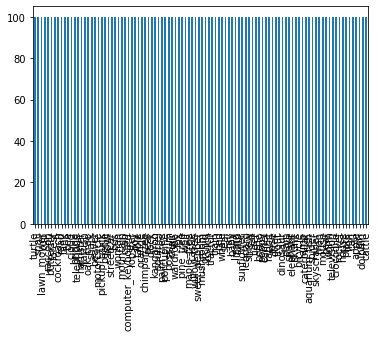

In [20]:
validate_df['category'].value_counts().plot.bar()

In [21]:
train_datagen = ImageDataGenerator(
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 50000 validated image filenames belonging to 100 classes.


In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TEST_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 10000 validated image filenames belonging to 100 classes.


In [23]:
print(train_df.shape)
print(validate_df.shape)

(50000, 2)
(10000, 2)


In [24]:
train_generator.image_shape

(128, 128, 3)

In [25]:
NUM_CLASSES = len(train_df['category'].value_counts())
print(NUM_CLASSES)

100


In [26]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    Dropout(0.1),
    layers.Dense(4096),
    layers.Activation("relu"),
    layers.BatchNormalization(),
    Dropout(0.1),
    layers.Dense(4096),
    layers.Activation("relu"),
    layers.BatchNormalization(),
    Dropout(0.1),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

import copy
untrained_layers = copy.deepcopy([classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights(),
                                  classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX+1].name).get_weights()])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 32)      21632     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
activation_7 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 128)       36992     
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 128)      

In [14]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    Dropout(0.25),
    layers.Dense(4096),
    layers.Activation("relu"),
    layers.BatchNormalization(),
    Dropout(0.25),
    layers.Dense(4096),
    layers.Activation("relu"),
    layers.BatchNormalization(),
    Dropout(0.25),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

import copy
untrained_layers = copy.deepcopy([classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights(),
                                  classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX+1].name).get_weights()])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      21632     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       36992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       5

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
1562/1562 [==============================] - 69s 40ms/step - loss: 5.9024 - accuracy: 0.0533 - auc: 0.6465 - val_loss: 5.6735 - val_accuracy: 0.0511 - val_auc: 0.6403
Epoch 2/1000
1562/1562 [==============================] - 62s 40ms/step - loss: 4.3827 - accuracy: 0.1331 - auc: 0.7801 - val_loss: 3.2145 - val_accuracy: 0.2326 - val_auc: 0.8704
Epoch 3/1000
1562/1562 [==============================] - 62s 40ms/step - loss: 3.1633 - accuracy: 0.2445 - auc: 0.8728 - val_loss: 3.0045 - val_accuracy: 0.2801 - val_auc: 0.8858
Epoch 4/1000
1562/1562 [==============================] - 62s 40ms/step - loss: 2.6754 - accuracy: 0.3213 - auc: 0.9133 - val_loss: 2.8499 - val_accuracy: 0.3174 - val_auc: 0.8892
Epoch 5/1000
1562/1562 [==============================] - 62s 40ms/step - loss: 2.3771 - accuracy: 0.3840 - auc: 0.9323 - val_loss: 2.3607 - val_accuracy: 0.3958 - val_auc: 0.9308
Epoch 6/1000
1562/1562 [==============================] - 62s 40ms/step - loss: 2.1830 - accuracy: 0